In [1]:
# We'll create a reusable function + example data structure for your benchmark plot.
# The function lets you pass:
# - data (list[dict]) OR just player_name (with default demo data)
# - title (optional)
# - background color (hex or named)
# - optional colors for the player point and the typical band
# - save_path (optional) and show (bool)
#
# It also writes a standalone Python module with the function for reuse.

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os, textwrap, json

In [3]:
def _luminance(hex_color):
    """Return perceived luminance 0..1 (simple formula) for auto text coloring."""
    c = hex_color.strip().lstrip("#")
    if len(c) == 3:
        c = "".join([ch*2 for ch in c])
    r = int(c[0:2], 16)/255.0
    g = int(c[2:4], 16)/255.0
    b = int(c[4:6], 16)/255.0
    # Relative luminance approximation
    return 0.2126*r + 0.7152*g + 0.0722*b

def create_dc_benchmark(
    data=None,
    player_name=None,
    title=None,
    background="#12131a",
    player_color="#2bff3f",
    typical_color="#1da634",
    save_path=None,
    show=True
):
    """
    Create a professional benchmark visualization for a centre-back vs a 'typical' N3 adult range.
    
    Parameters
    ----------
    data : list of dicts
        Each dict must include:
        - label (str): metric name
        - player (float): player value
        - typical_low (float): low end of typical range
        - typical_high (float): high end of typical range
        - scale_min (float): axis min for that row
        - scale_max (float): axis max for that row
        - unit (str): "/90" or "%", will be printed next to the typical label
    player_name : str, optional
        If provided, used in subtitle. Not required.
    title : str, optional
        Main chart title. If None, a sensible default is used.
    background : str, optional
        Figure background color (hex or named). Also used for axes facecolor.
    player_color : str, optional
        Color for player markers.
    typical_color : str, optional
        Color for typical range bars.
    save_path : str, optional
        If provided, saves the figure to this path.
    show : bool
        If True, displays the chart.
    """
    # Default demo data if none provided
    if data is None:
        data = [
            {"label":"Tackles attempted","player":1.55,"typical_low":1.2,"typical_high":2.0,"scale_min":0.0,"scale_max":3.0,"unit":"/90"},
            {"label":"Tackle success %","player":62.6,"typical_low":60.0,"typical_high":70.0,"scale_min":40.0,"scale_max":80.0,"unit":"%"},
            {"label":"Aerial duels attempted","player":1.93,"typical_low":3.0,"typical_high":5.0,"scale_min":0.0,"scale_max":6.0,"unit":"/90"},
            {"label":"Aerial duel success %","player":30.1,"typical_low":55.0,"typical_high":65.0,"scale_min":0.0,"scale_max":80.0,"unit":"%"},
            {"label":"Recoveries","player":8.3,"typical_low":6.0,"typical_high":9.0,"scale_min":3.0,"scale_max":12.0,"unit":"/90"},
            {"label":"Passes completed","player":48.0,"typical_low":30.0,"typical_high":50.0,"scale_min":20.0,"scale_max":70.0,"unit":"/90"},
            {"label":"Pass accuracy %","player":85.7,"typical_low":80.0,"typical_high":88.0,"scale_min":70.0,"scale_max":95.0,"unit":"%"},
            {"label":"Forward passes completed","player":19.3,"typical_low":12.0,"typical_high":22.0,"scale_min":0.0,"scale_max":30.0,"unit":"/90"},
            {"label":"Forward pass accuracy %","player":74.2,"typical_low":65.0,"typical_high":75.0,"scale_min":50.0,"scale_max":85.0,"unit":"%"},
            {"label":"Key passes","player":0.39,"typical_low":0.10,"typical_high":0.40,"scale_min":0.0,"scale_max":0.8,"unit":"/90"},
        ]
    # Sort or keep order as provided
    labels = [d["label"] for d in data]
    y_positions = np.arange(len(data))[::-1]

    # Auto text color based on background
    lum = _luminance(background if background.startswith("#") else "#12131a")
    text_color = "#0b0d0f" if lum > 0.6 else "#E6F5E6"
    subtle_text = "#2A2A2A" if lum > 0.6 else "#B8D9B8"
    grid_color = "#DDDDDD" if lum > 0.7 else "#2B333B"
    axis_edge = "#CCCCCC" if lum > 0.7 else "#36404a"

    # Style
    plt.rcParams.update({
        "figure.facecolor": background,
        "axes.facecolor": background,
        "axes.edgecolor": axis_edge,
        "axes.labelcolor": text_color,
        "xtick.color": text_color,
        "ytick.color": text_color,
        "text.color": text_color,
        "grid.color": grid_color,
        "font.size": 12,
    })

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels)
    # Draw rows
    for i, d in enumerate(data):
        y = y_positions[i]
        smin, smax = d["scale_min"], d["scale_max"]
        lo, hi = d["typical_low"], d["typical_high"]
        player = d["player"]
        unit = d["unit"]
        # background track
        ax.hlines(y, smin, smax, color=grid_color, linewidth=16, zorder=1, alpha=0.35)
        # typical band
        ax.add_patch(Rectangle((lo, y-0.35), hi-lo, 0.7, color=typical_color, alpha=0.85, zorder=2))
        # player marker
        ax.plot(player, y, marker="o", markersize=10, color=player_color, zorder=3)
        # labels
        ax.text(player, y+0.42, f"{player:.2f}", ha="center", va="bottom", fontsize=10, color=text_color)
        ax.text(hi, y-0.42, f"Typical: {lo:g}–{hi:g} {unit}", ha="right", va="top", fontsize=9, color=subtle_text)

    # Axes
    xmin = min(d["scale_min"] for d in data)
    xmax = max(d["scale_max"] for d in data)
    ax.set_xlim(xmin, xmax)
    ax.grid(axis="x", linestyle="--", linewidth=0.8, alpha=0.4)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.set_xlabel("Per-90 or percentage scale")

    # Titles
    main_title = title or "Benchmark — Centre-Back vs. Typical Adult N3"
    subtitle_frags = []
    if player_name:
        subtitle_frags.append(f"Player: {player_name}")
    subtitle_frags.append("Green bar = typical range | Green dot = player value")
    subtitle = " — ".join(subtitle_frags)
    plt.suptitle(main_title, y=0.97, fontsize=18, fontweight="bold", color=text_color)
    ax.set_title(subtitle, fontsize=11, color=subtle_text, pad=16)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

# --- Example usage (you can replace with your own data) ---
example_data = [
    {"label":"Tackles attempted","player":1.55,"typical_low":1.2,"typical_high":2.0,"scale_min":0.0,"scale_max":3.0,"unit":"/90"},
    {"label":"Tackle success %","player":62.6,"typical_low":60.0,"typical_high":70.0,"scale_min":40.0,"scale_max":80.0,"unit":"%"},
    {"label":"Aerial duels attempted","player":1.93,"typical_low":3.0,"typical_high":5.0,"scale_min":0.0,"scale_max":6.0,"unit":"/90"},
    {"label":"Aerial duel success %","player":30.1,"typical_low":55.0,"typical_high":65.0,"scale_min":0.0,"scale_max":80.0,"unit":"%"},
    {"label":"Recoveries","player":8.3,"typical_low":6.0,"typical_high":9.0,"scale_min":3.0,"scale_max":12.0,"unit":"/90"},
    {"label":"Passes completed","player":48.0,"typical_low":30.0,"typical_high":50.0,"scale_min":20.0,"scale_max":70.0,"unit":"/90"},
    {"label":"Pass accuracy %","player":85.7,"typical_low":80.0,"typical_high":88.0,"scale_min":70.0,"scale_max":95.0,"unit":"%"},
    {"label":"Forward passes completed","player":19.3,"typical_low":12.0,"typical_high":22.0,"scale_min":0.0,"scale_max":30.0,"unit":"/90"},
    {"label":"Forward pass accuracy %","player":74.2,"typical_low":65.0,"typical_high":75.0,"scale_min":50.0,"scale_max":85.0,"unit":"%"},
    {"label":"Key passes","player":0.39,"typical_low":0.10,"typical_high":0.40,"scale_min":0.0,"scale_max":0.8,"unit":"/90"},
]

# Also write a tiny reusable module file
module_code = textwrap.dedent('''
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    import numpy as np

    def _luminance(hex_color):
        c = hex_color.strip().lstrip("#")
        if len(c) == 3:
            c = "".join([ch*2 for ch in c])
        r = int(c[0:2], 16)/255.0
        g = int(c[2:4], 16)/255.0
        b = int(c[4:6], 16)/255.0
        return 0.2126*r + 0.7152*g + 0.0722*b

    def create_dc_benchmark(
        data,
        player_name=None,
        title=None,
        background="#12131a",
        player_color="#2bff3f",
        typical_color="#1da634",
        save_path=None,
        show=True
    ):
        """
        Create a benchmark visualization for a centre-back vs a 'typical' adult N3 range.

        data : list of dicts with keys
            label, player, typical_low, typical_high, scale_min, scale_max, unit
        """
        labels = [d["label"] for d in data]
        y_positions = np.arange(len(data))[::-1]

        lum = _luminance(background if background.startswith("#") else "#12131a")
        text_color = "#0b0d0f" if lum > 0.6 else "#E6F5E6"
        subtle_text = "#2A2A2A" if lum > 0.6 else "#B8D9B8"
        grid_color = "#DDDDDD" if lum > 0.7 else "#2B333B"
        axis_edge = "#CCCCCC" if lum > 0.7 else "#36404a"

        plt.rcParams.update({
            "figure.facecolor": background,
            "axes.facecolor": background,
            "axes.edgecolor": axis_edge,
            "axes.labelcolor": text_color,
            "xtick.color": text_color,
            "ytick.color": text_color,
            "text.color": text_color,
            "grid.color": grid_color,
            "font.size": 12,
        })

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels)

        for i, d in enumerate(data):
            y = y_positions[i]
            smin, smax = d["scale_min"], d["scale_max"]
            lo, hi = d["typical_low"], d["typical_high"]
            player = d["player"]
            unit = d["unit"]

            ax.hlines(y, smin, smax, color=grid_color, linewidth=16, zorder=1, alpha=0.35)
            ax.add_patch(Rectangle((lo, y-0.35), hi-lo, 0.7, color=typical_color, alpha=0.85, zorder=2))
            ax.plot(player, y, marker="o", markersize=10, color=player_color, zorder=3)

            ax.text(player, y+0.42, f"{player:.2f}", ha="center", va="bottom", fontsize=10, color=text_color)
            ax.text(hi, y-0.42, f"Typical: {lo:g}–{hi:g} {unit}", ha="right", va="top", fontsize=9, color=subtle_text)

        ax.set_xlim(min(d["scale_min"] for d in data), max(d["scale_max"] for d in data))
        ax.grid(axis="x", linestyle="--", linewidth=0.8, alpha=0.4)
        ax.tick_params(axis='y', which='major', pad=10)
        ax.set_xlabel("Per-90 or percentage scale")

        main_title = title or "Benchmark — Centre-Back vs. Typical Adult N3"
        subtitle = []
        if player_name:
            subtitle.append(f"Player: {player_name}")
        subtitle.append("Green bar = typical range | Green dot = player value")
        subtitle = " — ".join(subtitle)

        plt.suptitle(main_title, y=0.97, fontsize=18, fontweight="bold", color=text_color)
        ax.set_title(subtle_text, fontsize=11, color=subtle_text, pad=16)

        fig.tight_layout(rect=[0, 0.03, 1, 0.94])

        if save_path:
            plt.savefig(save_path, dpi=200, bbox_inches="tight")
        if show:
            plt.show()
        plt.close(fig)
''')


def build_benchmark_data(player_stats, typical_ranges, scales, units):
    data = []
    for label, player_val in player_stats.items():
        lo, hi = typical_ranges[label]
        smin, smax = scales[label]
        unit = units[label]
        data.append({
            "label": label,
            "player": float(player_val),
            "typical_low": float(lo),
            "typical_high": float(hi),
            "scale_min": float(smin),
            "scale_max": float(smax),
            "unit": unit,
        })
    return data

In [4]:
# --- 1) Données "joueur" (par 90 min, sauf %)
player_stats = {
    "Tackles attempted": 1.55,
    "Tackle success %": 62.6,
    "Aerial duels attempted": 1.93,
    "Aerial duel success %": 30.1,
    "Recoveries": 8.3,
    "Passes completed": 48.0,
    "Pass accuracy %": 85.7,
    "Forward passes completed": 19.3,
    "Forward pass accuracy %": 74.2,
    "Key passes": 0.39,
}

# --- 2) Données "défenseur typique N3 (adulte)" = fourchettes
typical_cb_ranges = {
    "Tackles attempted": (1.2, 2.0),
    "Tackle success %": (60.0, 70.0),
    "Aerial duels attempted": (3.0, 5.0),
    "Aerial duel success %": (55.0, 65.0),
    "Recoveries": (6.0, 9.0),
    "Passes completed": (30.0, 50.0),
    "Pass accuracy %": (80.0, 88.0),
    "Forward passes completed": (12.0, 22.0),
    "Forward pass accuracy %": (65.0, 75.0),
    "Key passes": (0.10, 0.40),
}

# --- 3) Échelles par métrique (pour les axes) et unités
scales = {
    "Tackles attempted": (0.0, 3.0),
    "Tackle success %": (40.0, 80.0),
    "Aerial duels attempted": (0.0, 6.0),
    "Aerial duel success %": (0.0, 80.0),
    "Recoveries": (3.0, 12.0),
    "Passes completed": (20.0, 70.0),
    "Pass accuracy %": (70.0, 95.0),
    "Forward passes completed": (0.0, 30.0),
    "Forward pass accuracy %": (50.0, 85.0),
    "Key passes": (0.0, 0.8),
}

units = {
    "Tackles attempted": "/90",
    "Tackle success %": "%",
    "Aerial duels attempted": "/90",
    "Aerial duel success %": "%",
    "Recoveries": "/90",
    "Passes completed": "/90",
    "Pass accuracy %": "%",
    "Forward passes completed": "/90",
    "Forward pass accuracy %": "%",
    "Key passes": "/90",
}


In [5]:
data = build_benchmark_data(player_stats, typical_cb_ranges, scales, units)
data[:2]  # aperçu

[{'label': 'Tackles attempted',
  'player': 1.55,
  'typical_low': 1.2,
  'typical_high': 2.0,
  'scale_min': 0.0,
  'scale_max': 3.0,
  'unit': '/90'},
 {'label': 'Tackle success %',
  'player': 62.6,
  'typical_low': 60.0,
  'typical_high': 70.0,
  'scale_min': 40.0,
  'scale_max': 80.0,
  'unit': '%'}]

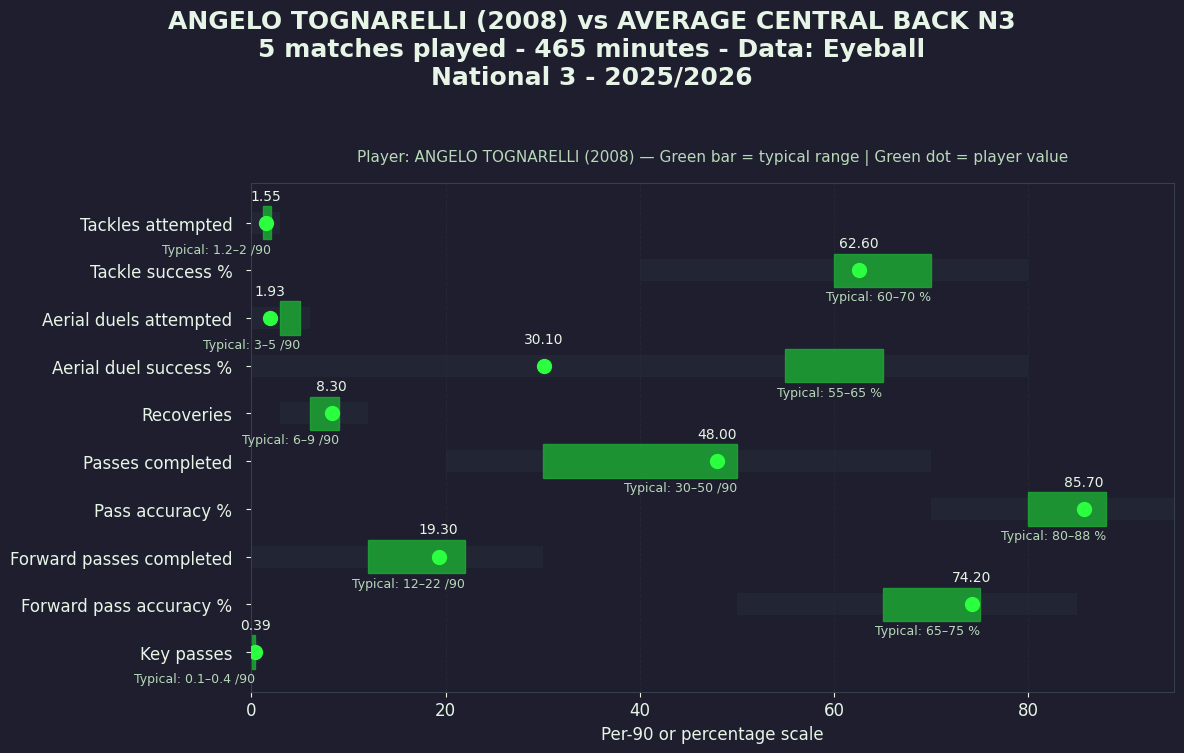

In [14]:
create_dc_benchmark(
    data=data,
    player_name="ANGELO TOGNARELLI (2008)",
    title="ANGELO TOGNARELLI (2008) vs AVERAGE CENTRAL BACK N3\n5 matches played - 465 minutes - Data: Eyeball\nNational 3 - 2025/2026",
    background="#1e1e2f",     # change la couleur ici
    save_path="tognarelli_eyeball_benchmark.png",
    show=True
)

In [8]:
# --- 1) Player data (per 90 unless noted as %)
player_stats = {
    "Goals": 0.28,
    "Assists": 0.42,
    "Shots": 0.97,

    "Successful dribbles": 3.60,
    "Dribble success %": 65.5,          # 3.6 / 5.5

    "Recoveries": 9.60,

    "Passes completed": 23.0,           # 23 / 36
    "Pass accuracy %": 65.0,

    "Key passes": 0.97,

    "Forward passes completed": 9.60,   # 9.6 / 18.0
    "Forward pass accuracy %": 53.3,

    "Crosses completed": 0.83,          # 0.83 / 3.2
    "Cross accuracy %": 25.9,
}

# --- 2) Typical right-back U17 (median) — ranges
typical_rb_u17_ranges = {
    "Goals": (0.05, 0.25),
    "Assists": (0.10, 0.35),
    "Shots": (0.30, 1.20),

    "Successful dribbles": (1.5, 3.0),
    "Dribble success %": (40.0, 60.0),

    "Recoveries": (4.0, 10.0),

    "Passes completed": (20.0, 40.0),
    "Pass accuracy %": (60.0, 85.0),

    "Key passes": (0.30, 1.20),

    "Forward passes completed": (7.0, 15.0),
    "Forward pass accuracy %": (50.0, 65.0),

    "Crosses completed": (0.40, 1.20),
    "Cross accuracy %": (20.0, 35.0),
}


# --- 3) Scales (axis limits) and units
scales = {
    "Goals": (0.0, 0.6),
    "Assists": (0.0, 0.8),
    "Shots": (0.0, 2.0),

    "Successful dribbles": (0.0, 6.0),
    "Dribble success %": (30.0, 80.0),

    "Recoveries": (3.0, 13.0),

    "Passes completed": (10.0, 55.0),
    "Pass accuracy %": (50.0, 95.0),

    "Key passes": (0.0, 2.0),

    "Forward passes completed": (0.0, 20.0),
    "Forward pass accuracy %": (40.0, 85.0),

    "Crosses completed": (0.0, 2.5),
    "Cross accuracy %": (10.0, 55.0),
}

units = {
    "Goals": "/90",
    "Assists": "/90",
    "Shots": "/90",

    "Successful dribbles": "/90",
    "Dribble success %": "%",

    "Recoveries": "/90",

    "Passes completed": "/90",
    "Pass accuracy %": "%",

    "Key passes": "/90",

    "Forward passes completed": "/90",
    "Forward pass accuracy %": "%",

    "Crosses completed": "/90",
    "Cross accuracy %": "%",
}

In [9]:
data = build_benchmark_data(player_stats, typical_rb_u17_ranges, scales, units)
data[:2]  # aperçu

[{'label': 'Goals',
  'player': 0.28,
  'typical_low': 0.05,
  'typical_high': 0.25,
  'scale_min': 0.0,
  'scale_max': 0.6,
  'unit': '/90'},
 {'label': 'Assists',
  'player': 0.42,
  'typical_low': 0.1,
  'typical_high': 0.35,
  'scale_min': 0.0,
  'scale_max': 0.8,
  'unit': '/90'}]

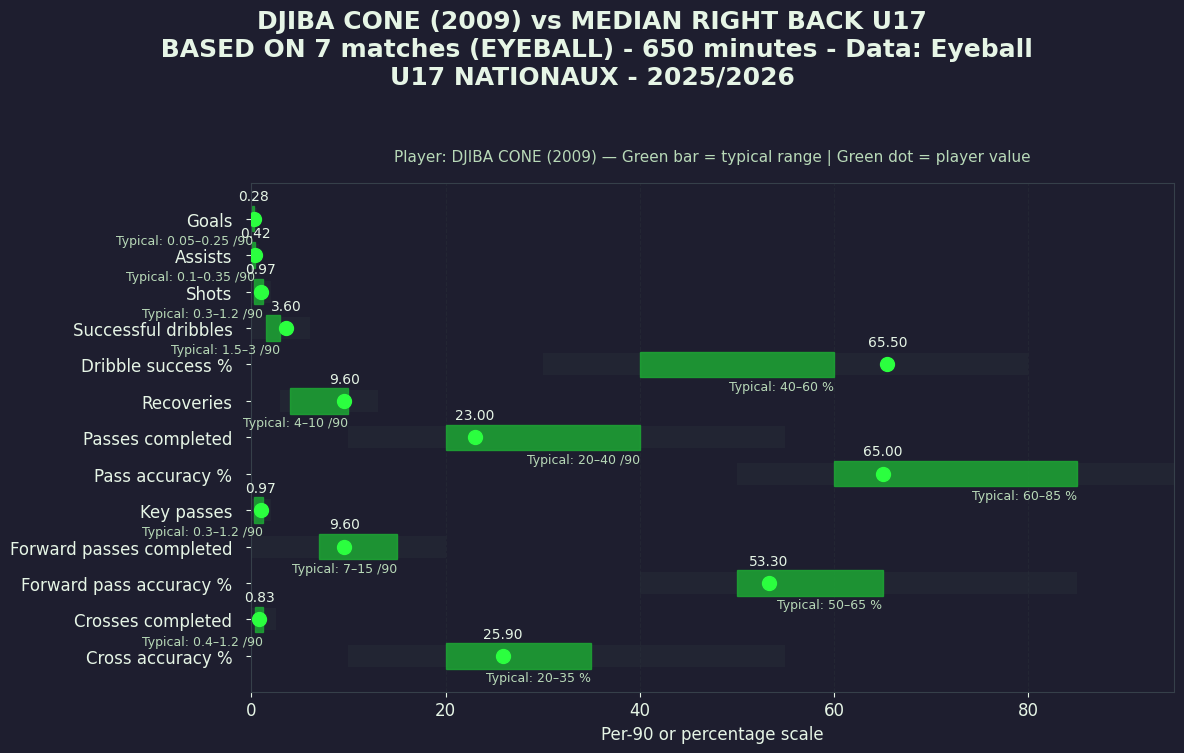

In [11]:
create_dc_benchmark(
    data=data,
    player_name="DJIBA CONE (2009)",
    title="DJIBA CONE (2009) vs MEDIAN RIGHT BACK U17\n BASED ON 7 matches (EYEBALL) - 650 minutes - Data: Eyeball\nU17 NATIONAUX - 2025/2026",
    background="#1e1e2f",     # change la couleur ici
    save_path="djiba_cone_eyeball_benchmark.png",
    show=True
)